In [1]:
import os 
import subprocess as sp
import numpy as np
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 

import seaborn as sns
import pybedtools as pbt 

import gzip
import csv

pbt.set_bedtools_path('/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/bin/')
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')

pd.set_option('display.max_rows', 500)

os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/jreyna-temp/projects/dchallenge/')

outdir = 'results/main/eqtl/eqtl_report/'
os.makedirs(outdir, exist_ok=True)

In [2]:
# load eqtl samplesheet
eqtl_samplesheet = pd.read_table('config/eqtl_samplesheets/eqtl.t1d_only.txt')
eqtl_samplesheet.loc[:, 'qarray_id'] = np.arange(2, eqtl_samplesheet.shape[0] + 2)

In [3]:
eqtl_samplesheet.eqtl_db = eqtl_samplesheet.eqtl_db.str.replace('#', '')

## Number of eQTL before filtering (eQTL Catalog)

In [4]:
before_data = []
before_glob = 'results/main/eqtl/*/ge/*_ge_*.all.prefilter.num_eqtls.txt'
before_glob = glob.glob(before_glob)

In [5]:
before_data = []
for fn in before_glob:
    with open(fn) as fr:
        
        eqtl, ge = os.path.basename(fn).split('_ge_')
        ge = ge.split('.')[0]
        
        num_eqtls = int(fr.read().strip())
        
        before_data.append([eqtl, ge, num_eqtls])

In [6]:
before_df = pd.DataFrame(before_data)
before_df.columns = ['eqtl', 'ge', 'num_eqtls_pre']

## Number of eQTL post filtering (eQTL Catalog)

In [7]:
post_data = []
post_glob = 'results/main/eqtl/*/ge/*_ge_*.all.postfilter.num_eqtls.txt'
post_glob = glob.glob(post_glob)

In [8]:
post_data = []
for fn in post_glob:
    with open(fn) as fr:
        
        eqtl, ge = os.path.basename(fn).split('_ge_')
        ge = ge.split('.')[0]
        
        
        value = fr.read().strip()
        
        if value != '':
            num_eqtls = int(value)
        else:
            num_eqtls = 0        
        
        post_data.append([eqtl, ge, num_eqtls])

In [9]:
post_df = pd.DataFrame(post_data)
post_df.columns = ['eqtl', 'ge', 'num_eqtls_post']

In [10]:
post_df

,eqtl,ge,num_eqtls_post
0,Lepik_2017,blood,2946020
1,ImmuNexUT,CL_Mono,2232482
2,ImmuNexUT,Neu,2061244
3,ImmuNexUT,Th2,1726544
4,ImmuNexUT,Naive_CD8,1819410
5,ImmuNexUT,Th1,1716189
6,ImmuNexUT,CD16p_Mono,2192186
7,ImmuNexUT,NC_Mono,1587733
8,ImmuNexUT,pDC,2078397
9,ImmuNexUT,SM_B,1964129


## Compare the eQTL data  before and after FDR filtering

In [11]:
all_df = pd.merge(before_df, post_df, on=['eqtl', 'ge'], how='outer')
all_df['%Post'] = all_df['num_eqtls_post'] / all_df['num_eqtls_pre'] * 100

# adding the qsub array id 
all_df = all_df.merge(eqtl_samplesheet, left_on=['eqtl', 'ge'], right_on=['eqtl_db', 'eqtl_origin'])

In [12]:
pd.set_option('display.max_rows', 100) 
display(all_df)
pd.set_option('display.max_rows', 20) 

,eqtl,ge,num_eqtls_pre,num_eqtls_post,%Post,eqtl_db,eqtl_origin,qarray_id
0,Lepik_2017,blood,103124065,2946020,2.856773,Lepik_2017,blood,10
1,ImmuNexUT,Mem_CD4,91503125,1859035,2.031663,ImmuNexUT,Mem_CD4,43
2,ImmuNexUT,TEMRA_CD8,88023558,1351265,1.535117,ImmuNexUT,TEMRA_CD8,54
3,ImmuNexUT,NK,88189090,1726682,1.957932,ImmuNexUT,NK,50
4,ImmuNexUT,pDC,85996889,2078397,2.416828,ImmuNexUT,pDC,51
5,ImmuNexUT,Fr_II_eTreg,88794440,1672923,1.884040,ImmuNexUT,Fr_II_eTreg,37
6,ImmuNexUT,Tfh,91352934,1921385,2.103255,ImmuNexUT,Tfh,55
7,ImmuNexUT,USM_B,90812282,1711569,1.884733,ImmuNexUT,USM_B,59
8,ImmuNexUT,Th1,90175393,1716189,1.903168,ImmuNexUT,Th1,57
9,ImmuNexUT,DN_B,91481775,1680321,1.836782,ImmuNexUT,DN_B,35


In [13]:
t1d_related = pd.read_table('config/eqtl_samplesheets/eqtl.samplesheet.tsv')
t1d_related_eqtls = [['BLUEPRINT', 'monocyte'],
     ['BLUEPRINT', 'neutrophil'],
     ['BLUEPRINT', 'T-cell'],
     ['GENCORD', 'LCL'],
     ['GENCORD', 'T-cell'],
     ['GTEx', 'blood'],
     ['GTEx', 'LCL'],
     ['GTEx', 'liver'],
     ['GTEx', 'pancreas'],
     ['Lepik_2017', 'blood'],
     ['Quach_2016', 'monocyte_IAV'],
     ['Quach_2016', 'monocyte_LPS'],
     ['Quach_2016', 'monocyte_naive'],
     ['Quach_2016', 'monocyte_Pam3CSK4'],
     ['Quach_2016', 'monocyte_R848'],
     ['Schmiedel_2018', 'B-cell_naive'],
     ['Schmiedel_2018', 'CD4_T-cell_anti-CD3-CD28'],
     ['Schmiedel_2018', 'CD4_T-cell_naive'],
     ['Schmiedel_2018', 'CD8_T-cell_anti-CD3-CD28'],
     ['Schmiedel_2018', 'CD8_T-cell_naive'],
     ['Schmiedel_2018', 'monocyte_CD16_naive'],
     ['Schmiedel_2018', 'monocyte_naive'],
     ['Schmiedel_2018', 'NK-cell_naive'],
     ['Schmiedel_2018', 'Tfh_memory'],
     ['Schmiedel_2018', 'Th1-17_memory'],
     ['Schmiedel_2018', 'Th17_memory'],
     ['Schmiedel_2018', 'Th1_memory'],
     ['Schmiedel_2018', 'Th2_memory'],
     ['Schmiedel_2018', 'Treg_memory'],
     ['Schmiedel_2018', 'Treg_naive'],
     ['van_de_Bunt_2015', 'pancreatic_islet'],
     ['ImmuNexUT', 'CD16p_Mono'],
     ['ImmuNexUT', 'CL_Mono'],
     ['ImmuNexUT', 'CM_CD8'],
     ['ImmuNexUT', 'DN_B'],
     ['ImmuNexUT', 'EM_CD8'],
     ['ImmuNexUT', 'Fr_II_eTreg'],
     ['ImmuNexUT', 'Fr_III_T'],
     ['ImmuNexUT', 'Fr_I_nTreg'],
     ['ImmuNexUT', 'Int_Mono'],
     ['ImmuNexUT', 'LDG'],
     ['ImmuNexUT', 'mDC'],
     ['ImmuNexUT', 'Mem_CD4'],
     ['ImmuNexUT', 'Mem_CD8'],
     ['ImmuNexUT', 'Naive_B'],
     ['ImmuNexUT', 'Naive_CD4'],
     ['ImmuNexUT', 'Naive_CD8'],
     ['ImmuNexUT', 'NC_Mono'],
     ['ImmuNexUT', 'Neu'],
     ['ImmuNexUT', 'NK'],
     ['ImmuNexUT', 'pDC'],
     ['ImmuNexUT', 'Plasmablast'],
     ['ImmuNexUT', 'SM_B'],
     ['ImmuNexUT', 'TEMRA_CD8'],
     ['ImmuNexUT', 'Tfh'],
     ['ImmuNexUT', 'Th17'],
     ['ImmuNexUT', 'Th1'],
     ['ImmuNexUT', 'Th2'],
     ['ImmuNexUT', 'USM_B']]

In [14]:
num_immunexut = len([x[0] for x in t1d_related_eqtls if x[0] == 'ImmuNexUT'])
curr_poss_eqtls = len(t1d_related_eqtls) - num_immunexut
print(curr_poss_eqtls)

31


In [15]:
bools = []
for sr in all_df.iloc[:, [0,1]].values:
    if sr.tolist() in t1d_related_eqtls:
        bools.append(True)
    else:
        bools.append(False)

In [16]:
all_df = all_df.loc[bools]

In [17]:
all_df

,eqtl,ge,num_eqtls_pre,num_eqtls_post,%Post,eqtl_db,eqtl_origin,qarray_id
0,Lepik_2017,blood,103124065,2946020,2.856773,Lepik_2017,blood,10
1,ImmuNexUT,Mem_CD4,91503125,1859035,2.031663,ImmuNexUT,Mem_CD4,43
2,ImmuNexUT,TEMRA_CD8,88023558,1351265,1.535117,ImmuNexUT,TEMRA_CD8,54
3,ImmuNexUT,NK,88189090,1726682,1.957932,ImmuNexUT,NK,50
4,ImmuNexUT,pDC,85996889,2078397,2.416828,ImmuNexUT,pDC,51
...,...,...,...,...,...,...,...,...
53,Schmiedel_2018,CD8_T-cell_anti-CD3-CD28,141347873,510059,0.360854,Schmiedel_2018,CD8_T-cell_anti-CD3-CD28,19
54,Schmiedel_2018,Th1_memory,153424768,513914,0.334962,Schmiedel_2018,Th1_memory,27
55,Schmiedel_2018,B-cell_naive,154773799,633355,0.409213,Schmiedel_2018,B-cell_naive,16
56,Schmiedel_2018,CD8_T-cell_naive,155723260,706670,0.453799,Schmiedel_2018,CD8_T-cell_naive,20


In [18]:
all_df.shape

(58, 8)

In [19]:
t1d_related_eqtls

[['BLUEPRINT', 'monocyte'],
 ['BLUEPRINT', 'neutrophil'],
 ['BLUEPRINT', 'T-cell'],
 ['GENCORD', 'LCL'],
 ['GENCORD', 'T-cell'],
 ['GTEx', 'blood'],
 ['GTEx', 'LCL'],
 ['GTEx', 'liver'],
 ['GTEx', 'pancreas'],
 ['Lepik_2017', 'blood'],
 ['Quach_2016', 'monocyte_IAV'],
 ['Quach_2016', 'monocyte_LPS'],
 ['Quach_2016', 'monocyte_naive'],
 ['Quach_2016', 'monocyte_Pam3CSK4'],
 ['Quach_2016', 'monocyte_R848'],
 ['Schmiedel_2018', 'B-cell_naive'],
 ['Schmiedel_2018', 'CD4_T-cell_anti-CD3-CD28'],
 ['Schmiedel_2018', 'CD4_T-cell_naive'],
 ['Schmiedel_2018', 'CD8_T-cell_anti-CD3-CD28'],
 ['Schmiedel_2018', 'CD8_T-cell_naive'],
 ['Schmiedel_2018', 'monocyte_CD16_naive'],
 ['Schmiedel_2018', 'monocyte_naive'],
 ['Schmiedel_2018', 'NK-cell_naive'],
 ['Schmiedel_2018', 'Tfh_memory'],
 ['Schmiedel_2018', 'Th1-17_memory'],
 ['Schmiedel_2018', 'Th17_memory'],
 ['Schmiedel_2018', 'Th1_memory'],
 ['Schmiedel_2018', 'Th2_memory'],
 ['Schmiedel_2018', 'Treg_memory'],
 ['Schmiedel_2018', 'Treg_naive'],
 ['

In [20]:
post_eqtl_means = all_df.num_eqtls_post.mean()
print('Mean number of significant eQTLs: {:.1f}'.format(post_eqtl_means))

Mean number of significant eQTLs: 1308540.4


In [21]:
all_df

,eqtl,ge,num_eqtls_pre,num_eqtls_post,%Post,eqtl_db,eqtl_origin,qarray_id
0,Lepik_2017,blood,103124065,2946020,2.856773,Lepik_2017,blood,10
1,ImmuNexUT,Mem_CD4,91503125,1859035,2.031663,ImmuNexUT,Mem_CD4,43
2,ImmuNexUT,TEMRA_CD8,88023558,1351265,1.535117,ImmuNexUT,TEMRA_CD8,54
3,ImmuNexUT,NK,88189090,1726682,1.957932,ImmuNexUT,NK,50
4,ImmuNexUT,pDC,85996889,2078397,2.416828,ImmuNexUT,pDC,51
...,...,...,...,...,...,...,...,...
53,Schmiedel_2018,CD8_T-cell_anti-CD3-CD28,141347873,510059,0.360854,Schmiedel_2018,CD8_T-cell_anti-CD3-CD28,19
54,Schmiedel_2018,Th1_memory,153424768,513914,0.334962,Schmiedel_2018,Th1_memory,27
55,Schmiedel_2018,B-cell_naive,154773799,633355,0.409213,Schmiedel_2018,B-cell_naive,16
56,Schmiedel_2018,CD8_T-cell_naive,155723260,706670,0.453799,Schmiedel_2018,CD8_T-cell_naive,20


In [22]:
all_df.loc[(all_df.num_eqtls_pre == 0)].sort_values('qarray_id')

,eqtl,ge,num_eqtls_pre,num_eqtls_post,%Post,eqtl_db,eqtl_origin,qarray_id


In [23]:
np.sum(all_df.num_eqtls_pre == 0)

0

In [24]:
np.sum(all_df.num_eqtls_post == 0)

0

#### Summary of min and max 

In [25]:
all_df.iloc[all_df.num_eqtls_post.argmax()]

eqtl              Lepik_2017
ge                     blood
num_eqtls_pre      103124065
num_eqtls_post       2946020
%Post                2.85677
eqtl_db           Lepik_2017
eqtl_origin            blood
qarray_id                 10
Name: 0, dtype: object

In [26]:
all_df.iloc[all_df.num_eqtls_post.argmin()]

eqtl              van_de_Bunt_2015
ge                pancreatic_islet
num_eqtls_pre            180559672
num_eqtls_post              178434
%Post                    0.0988227
eqtl_db           van_de_Bunt_2015
eqtl_origin       pancreatic_islet
qarray_id                       31
Name: 57, dtype: object

## Visualize eQTL Results

In [27]:
eqtl_colors ={'BLUEPRINT': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
             'GENCORD': (1.0, 0.4980392156862745, 0.054901960784313725),
             'GTEx': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             'ImmuNexUT': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
             'Lepik_2017': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             'Quach_2016': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             'Schmiedel_2018': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             'van_de_Bunt_2015': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)}

Text(0.5, 0, 'Count')

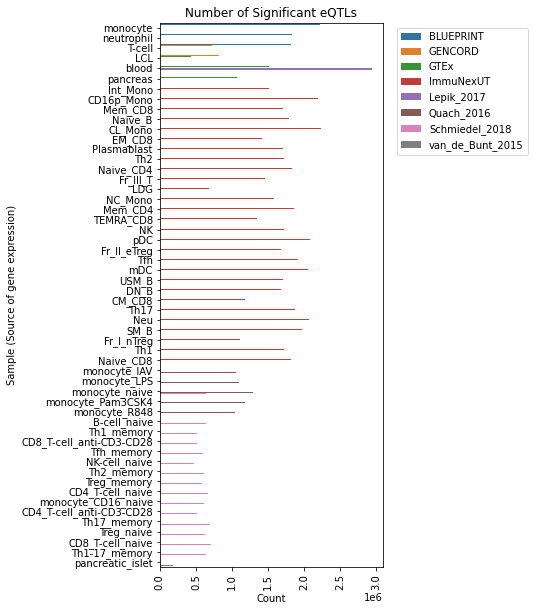

In [28]:
fig, ax = plt.subplots(figsize=(4, 10))

# Draw a nested barplot by species and sex
plot_data = all_df.sort_values('eqtl')

g = sns.barplot(data=plot_data,   
            y="ge", x="num_eqtls_post",
            hue='eqtl', palette=eqtl_colors, orient='h', ax=ax)

# move the legend
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

for x in g.get_xticklabels():
    x.set_rotation(90)

g.set_title('Number of Significant eQTLs')
g.set_ylabel('Sample (Source of gene expression)')
g.set_xlabel('Count')

## Write the report

In [29]:
report_fn = os.path.join(outdir, 'eqtl_report.tsv')
all_df.to_csv(report_fn, sep='\t', index=False)

## Check the number of studies that can contribute to each cell type

In [42]:
eqtls_main_cell_info = pd.read_table('config/eqtl_samplesheets/eqtl.t1d_only.with_main_cells.tsv')

In [31]:
eqtls_cts = eqtls_main_cell_info.iloc[:, 2:6].sum()
eqtls_cts = eqtls_cts.to_frame().reset_index()
eqtls_cts.columns = ['orig_cell_type', 'num_studies']

# add main cell names
main_cells = {'B-cell_naive': 'B-cells',
          'CD4_T-cell_naive': 'CD4 T-cells',
          'CD8_T-cell_naive': 'CD8 T-cells',
          'monocyte_naive':'Monocytes'}

eqtls_cts['cell_type'] = eqtls_cts['orig_cell_type'].map(main_cells)
eqtls_cts

,orig_cell_type,num_studies,cell_type
0,B-cell_naive,10,B-cells
1,CD4_T-cell_naive,16,CD4 T-cells
2,CD8_T-cell_naive,19,CD8 T-cells
3,monocyte_naive,14,Monocytes


In [77]:
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

This is a good start, but I want to have the number of unique eQTLs per cell type, this won't really get me there.

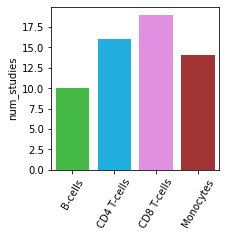

In [33]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x='cell_type', y='num_studies', hue='cell_type', palette=colors_dict, data=eqtls_cts, dodge=False)
ax.set_xlabel('')

ax.set_xticklabels(eqtls_cts['cell_type'], rotation = 60)
legend = ax.legend_
legend.set_visible(False)

hichip_summary_fn = os.path.join(outdir, 'eqtl_study_summary.svg')
fig.savefig(hichip_summary_fn)

## Calculate the Sum of Significant eQTLs Across Main Cell Types

In [79]:
# summarize the number of signficant eQTLs after FDR evaluation
eqtls_summarized = {k: 0 for k in eqtls_cts.orig_cell_type}

In [80]:
post_id_df = post_df.set_index(['eqtl', 'ge'])
for ID, sr in eqtls_main_cell_info.set_index(['eqtl_db', 'eqtl_source']).iterrows():    
    
    if ID not in post_id_df.index:
        print('ID: {} is missing from the post analysis. Please run this sample'.format(ID))
        print('Skipping for now.')
        continue
    
    if sr['B-cell_naive'] == 1:
        eqtls_summarized['B-cell_naive'] += post_id_df.loc[ID].num_eqtls_post
        
    if sr['CD4_T-cell_naive'] == 1:
        eqtls_summarized['CD4_T-cell_naive'] += post_id_df.loc[ID].num_eqtls_post
        
    if sr['CD8_T-cell_naive'] == 1:
        eqtls_summarized['CD8_T-cell_naive'] += post_id_df.loc[ID].num_eqtls_post
        
    if sr['monocyte_naive'] == 1:
        eqtls_summarized['monocyte_naive'] += post_id_df.loc[ID].num_eqtls_post
        

ID: ('Bossini-Castillo_2019', 'Treg_naive') is missing from the post analysis. Please run this sample
Skipping for now.


In [81]:
# temporary way to add NK
count_nk = post_id_df.reset_index()
count_nk = count_nk.loc[count_nk['ge'].isin(['NK', 'NK-cell_naive'])]
count_nk = count_nk.num_eqtls_post.sum()

In [82]:
eqtls_summarized = pd.DataFrame.from_dict(eqtls_summarized, orient='index')
eqtls_summarized = eqtls_summarized.reset_index()
eqtls_summarized.columns = ['orig_cell_type', 'count']
eqtls_summarized['cell_type'] = eqtls_summarized['orig_cell_type'].map(main_cells)

In [83]:
eqtls_summarized.loc[4] = ['NK cells', count_nk, 'NK cells']

In [84]:
eqtls_summarized.sort_values('orig_cell_type', inplace=True)

In [87]:
eqtls_summarized

,orig_cell_type,count,cell_type
0,B-cell_naive,15203230,B-cells
1,CD4_T-cell_naive,16151783,CD4 T-cells
2,CD8_T-cell_naive,27170414,CD8 T-cells
4,NK cells,2198684,NK cells
3,monocyte_naive,21127964,Monocytes


/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


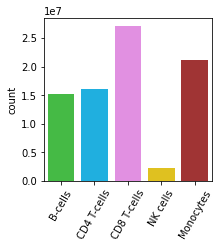

In [89]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x='cell_type', y='count', hue='cell_type', palette=colors_dict, data=eqtls_summarized, dodge=False)
ax.set_xlabel('')

ax.set_xticklabels(eqtls_summarized['cell_type'], rotation = 60)
legend = ax.legend_
legend.set_visible(False)

hichip_summary_fn = os.path.join(outdir, 'eqtl_eqtl_sum_summary.svg')
fig.savefig(hichip_summary_fn, bb_inches='tight')

## Characterizing the genes

In [41]:
print('# Load the gene data')

genes_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'

# load the gencode coords
cols = ['chrom', 'start', 'end', 'strand', 'type', 'gene_id', 'gname']
gencode = pd.read_table(genes_fn, header=None, names=cols)

# extract just the genes
genes_df = gencode.loc[gencode['type'].isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='gene_id'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df = genes_df.iloc[:, [0,1,2,6,5,3]]

# create a copy of the original gene bed before coordinate shrinking
orig_genes_df = genes_df.copy()

# convert the start/end position into start/end for the TSS
# if the gene is + then the start is uses as the tss otherwise
# the end is used as the tss
# genes_df.loc[(genes_df.strand == '+'), 'end'] = genes_df.loc[(genes_df.strand == '+'), 'start']
# genes_df.loc[(genes_df.strand == '+'), 'start'] = genes_df.loc[(genes_df.strand == '+'), 'start'] - 1
# genes_df.loc[(genes_df.strand == '-'), 'end'] = genes_df.loc[(genes_df.strand == '-'), 'end']
# genes_df.loc[(genes_df.strand == '-'), 'start'] = genes_df.loc[(genes_df.strand == '-'), 'end'] - 1
# genes_df.loc[:, 'chrom'] = genes_df.loc[:, 'chrom'].str.replace('chr', '')
# genes_df.loc[:, 'bin_start'] = (np.floor(genes_df.loc[:, 'start'] / res) * res).astype(int)
# genes_df.loc[:, 'bin_end'] = genes_df.loc[:, 'bin_start'] + res

# make a genes pbt for intersection
print("# make a genes pbt for intersection")
print(genes_df.head())
genes_pbt = pbt.BedTool.from_dataframe(genes_df).sort()

print('There are {} genes in this GTF-derived file.'.format(genes_df.shape[0]))

# Load the gene data
# make a genes pbt for intersection
   chrom  start    end        gname          gene_id strand
0   chr1  11869  14409      DDX11L1  ENSG00000223972      +
12  chr1  14404  29570       WASH7P  ENSG00000227232      -
25  chr1  17369  17436    MIR6859-1  ENSG00000278267      -
28  chr1  29554  31109  MIR1302-2HG  ENSG00000243485      +
36  chr1  30366  30503    MIR1302-2  ENSG00000284332      +
There are 58825 genes in this GTF-derived file.


In [69]:
gene_set = set()
eqtl_glob = 'results/main/eqtl/{0}/ge/{0}_ge_{1}.all.dist.fdr.tsv.gz'

In [ ]:
for file_info in t1d_related_eqtls:
    
    fn = eqtl_glob.format(file_info[0], file_info[1])
    
    print(fn)
        
    with gzip.open(fn, 'rt') as fh:
        
        # skip header
        next(fh)
        
        fh_csv = csv.reader(fh, delimiter='\t')
        for line in fh_csv:
            
            if float(line[20]) < 0.05:
                gene_set.add(line[0])

results/main/eqtl/BLUEPRINT/ge/BLUEPRINT_ge_monocyte.all.dist.fdr.tsv.gz
results/main/eqtl/BLUEPRINT/ge/BLUEPRINT_ge_neutrophil.all.dist.fdr.tsv.gz
results/main/eqtl/BLUEPRINT/ge/BLUEPRINT_ge_T-cell.all.dist.fdr.tsv.gz
results/main/eqtl/GENCORD/ge/GENCORD_ge_LCL.all.dist.fdr.tsv.gz
results/main/eqtl/GENCORD/ge/GENCORD_ge_T-cell.all.dist.fdr.tsv.gz
results/main/eqtl/GTEx/ge/GTEx_ge_blood.all.dist.fdr.tsv.gz
results/main/eqtl/GTEx/ge/GTEx_ge_LCL.all.dist.fdr.tsv.gz
results/main/eqtl/GTEx/ge/GTEx_ge_liver.all.dist.fdr.tsv.gz
results/main/eqtl/GTEx/ge/GTEx_ge_pancreas.all.dist.fdr.tsv.gz
results/main/eqtl/Lepik_2017/ge/Lepik_2017_ge_blood.all.dist.fdr.tsv.gz
results/main/eqtl/Quach_2016/ge/Quach_2016_ge_monocyte_IAV.all.dist.fdr.tsv.gz
results/main/eqtl/Quach_2016/ge/Quach_2016_ge_monocyte_LPS.all.dist.fdr.tsv.gz
results/main/eqtl/Quach_2016/ge/Quach_2016_ge_monocyte_naive.all.dist.fdr.tsv.gz
results/main/eqtl/Quach_2016/ge/Quach_2016_ge_monocyte_Pam3CSK4.all.dist.fdr.tsv.gz
results/main/e

In [ ]:
gene_data = pd.DataFrame(gene_set)

In [ ]:
gene_data.columns = ['geneid']

In [ ]:
gene_data.merge()

In [ ]:
7 + 7 